In [1]:
from urllib.request import urlretrieve
from pathlib import Path

import numpy as np
import tensorflow as tf
import tensorflow_federated as tff
from scipy.io import loadmat
import pandas as pd
import matplotlib.pyplot as plt

2024-05-29 14:46:59.849578: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-29 14:47:00.008484: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-29 14:47:00.008516: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-29 14:47:00.009422: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-29 14:47:00.092038: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-29 14:47:00.092862: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

In [2]:
NUM_CLIENTS = 725  # approx as many examples per client as in tff emnist in train set

In [3]:
DS_CACHE = Path("/home/ole/masterarbeit/flidp/dataset-cache/svhn")
train_mat_path = DS_CACHE / "train.mat"
test_mat_path = DS_CACHE / "test.mat"

In [4]:
train_url, test_url = "http://ufldl.stanford.edu/housenumbers/train_32x32.mat", "http://ufldl.stanford.edu/housenumbers/test_32x32.mat"
urlretrieve(train_url, train_mat_path)
urlretrieve(test_url, test_mat_path)

(PosixPath('/home/ole/masterarbeit/flidp/dataset-cache/svhn/test.mat'),
 <http.client.HTTPMessage at 0x7e26589ab5d0>)

In [5]:
def df_from_mat(mat_file):
    mat = loadmat(mat_file)
    X, y = mat['X'], mat['y']
    X = np.moveaxis(X, [3], [0])  # change example dimension to be the first dimension
    y = y.squeeze()
    X = list(X)
    y = list(0 if i == 10 else i for i in y)
    df = pd.DataFrame(data={'image': X, 'label': y})
    return df

In [6]:
def create_federated_df(mat_file, clients, client_probs=None):
    df = df_from_mat(mat_file)
    df['client_id'] = np.random.choice(clients, size=len(df), p=client_probs)
    return df

In [7]:
train_df = create_federated_df(train_mat_path, [f"client_{i}" for i in range(NUM_CLIENTS)])
test_df = create_federated_df(test_mat_path, [f"client_{i}" for i in range(NUM_CLIENTS)])

In [8]:
def make_client_getter(df):
    def get_tf_dataset_for_client(client_id):
        client_df = df[df['client_id'] == client_id]
        client_images = tf.convert_to_tensor(client_df['image'].to_list(), dtype=tf.int64)
        client_labels = tf.convert_to_tensor(client_df['label'].to_list(), dtype=tf.int64)
        
        client_ds = tf.data.Dataset.from_tensor_slices(
            {
                'image': client_images[:], 
                'label': client_labels[:],
            }
        )
        return client_ds
    return get_tf_dataset_for_client

In [9]:
# with `save_to_sql_client_data` it is not possible to specify a `split_name` for individual examples, only for clients *facepalm*
# see https://github.com/google-parfait/tensorflow-federated/blob/v0.79.0/tensorflow_federated/python/simulation/datasets/sql_client_data_utils.py#L233
# that's why I save train and test to different files
def make_sql_client_data(train_mat_file, test_mat_file, db_dir, num_clients):
    clients = [f"client_{i}" for i in range(num_clients)]

    train_df = create_federated_df(train_mat_file, clients)
    test_df = create_federated_df(test_mat_file, clients)
    
    tff.simulation.datasets.save_to_sql_client_data(
        client_ids=clients,
        dataset_fn=make_client_getter(train_df),
        database_filepath=str(Path(db_dir) / 'train.sqlite'),
        allow_overwrite=True,
    )
    tff.simulation.datasets.save_to_sql_client_data(
        client_ids=clients,
        dataset_fn=make_client_getter(test_df),
        database_filepath=str(Path(db_dir) / 'test.sqlite'),
        allow_overwrite=True,
    )

In [10]:
np.random.seed(42)
make_sql_client_data(train_mat_path, test_mat_path, DS_CACHE, NUM_CLIENTS)

In [11]:
def load_svhn(svhn_dir: str):
    svhn_spec = {
        'image': tf.TensorSpec((32, 32, 3), dtype=tf.int64),
        'label': tf.TensorSpec((), dtype=tf.int64),
    }
    train_client_data =  tff.simulation.datasets.load_and_parse_sql_client_data(str(Path(svhn_dir) / 'train.sqlite'), element_spec=svhn_spec, split_name=None)
    test_client_data = tff.simulation.datasets.load_and_parse_sql_client_data(str(Path(svhn_dir) / 'test.sqlite'), element_spec=svhn_spec, split_name=None)
    return train_client_data, test_client_data

In [12]:
train_ds, test_ds = load_svhn(DS_CACHE)

(<matplotlib.image.AxesImage at 0x7e262e399510>, 4)

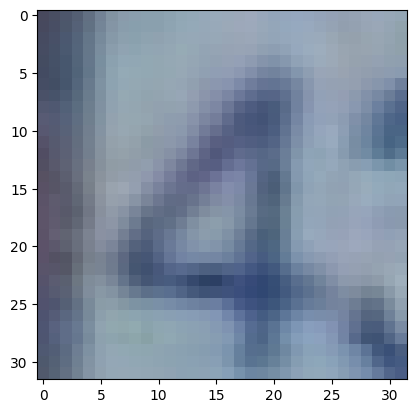

In [13]:
client_id = "client_1"
client_ds = train_ds.create_tf_dataset_for_client(client_id)
client_example = next(client_ds.as_numpy_iterator())
plt.imshow(client_example['image']), client_example['label']

In [14]:
len(list(train_ds.create_tf_dataset_from_all_clients().as_numpy_iterator()))

73257

In [15]:
len(list(test_ds.create_tf_dataset_from_all_clients().as_numpy_iterator()))

26032

In [16]:
max([len(list(train_ds.create_tf_dataset_for_client(c).as_numpy_iterator())) for c in train_ds.client_ids])

138

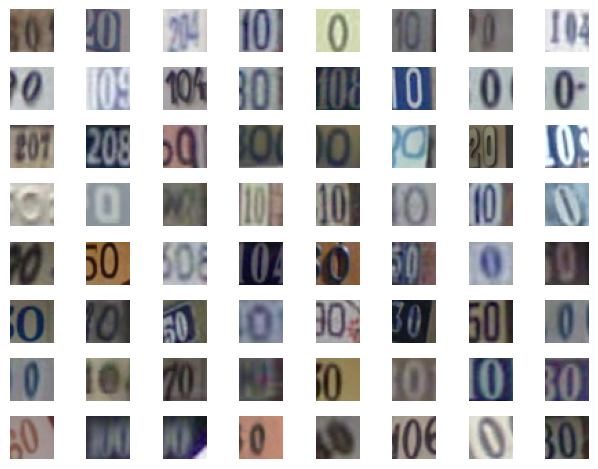

In [17]:
fig, axes = plt.subplots(8, 8)
flat_axes = axes.flatten()
for idx, ax in enumerate(flat_axes):
    img = train_df[train_df['label'] == 0]['image'].iloc[idx]
    ax.imshow(img)
    ax.axis('off')
plt.tight_layout()

In [18]:
train_df[train_df['label'] == 10]

,image,label,client_id
